TASK:-
1. define train_ds and test_df
2. visualizing the batch images using plyplot 
3. getting into conveyor pipeline (preprocessing and model training simultaneously for every image )

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt


In [21]:
from tensorflow.keras.utils import load_img ,array_to_img ,img_to_array , image_dataset_from_directory


In [33]:
# this is working for a single image only
img =  load_img("../dataset/Training/glioma_tumor/gg (1).jpg", target_size = (224,224))
img.size

(224, 224)

In [37]:
# Settings
IMG_SIZE = (224, 224) # Your target size
BATCH_SIZE = 32
TRAIN_DIR = '../dataset/Training'
TEST_DIR = '../dataset/Testing'

In [64]:
# Define Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed = 42
)

Found 2870 files belonging to 4 classes.


In [36]:
# Define Testing Dataset 
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed = 42
)

Found 394 files belonging to 4 classes.


In [ ]:
#to acces 1 image 
img = train_ds.take(1)
for i , l in img:
    img1 = i[0]
    plt.imshow(img1.numpy().astype("uint8"))
    plt.title(f"Label: {l[0].numpy()}")
    plt.axis("off")
    plt.show()


Full Batch Shape: (32, 224, 224, 3)


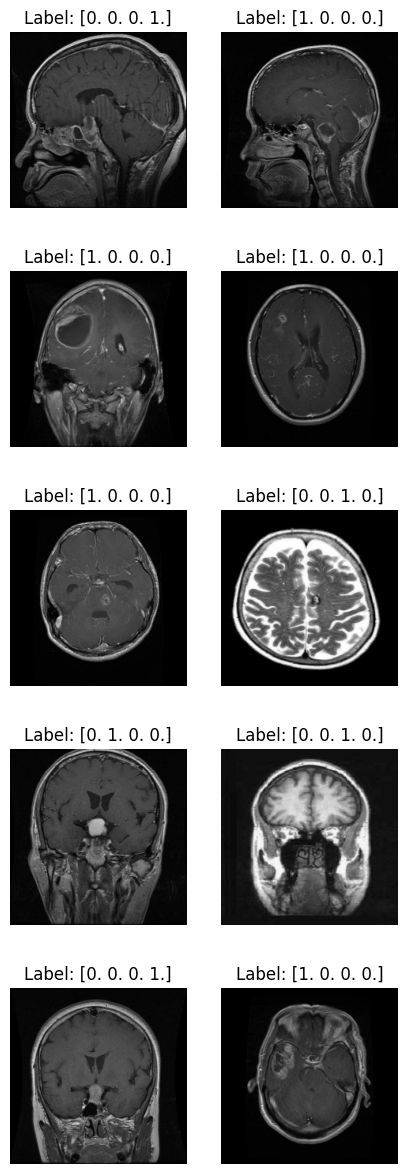

In [73]:
# to priint all image of the batch 
for i, l in train_ds.take(1):
    print(f"Full Batch Shape: {i.shape}") # This will show (32, 224, 224, 3)

    # We need a second loop to go through the 32 images inside 'i'
    plt.figure(figsize=(5, 15))  
    for index in range(10):
        ax = plt.subplot(5, 2, index + 1) # Create a grid (8 rows, 4 columns)
        
        # We grab image 'index' instead of just '0'
        plt.imshow(i[index].numpy().astype("uint8"))
        
        plt.title(f"Label: {l[index].numpy()}")
        plt.axis("off")
    plt.show()